# AutoDisk Demo

This is a demo of mapping normal and shear strain with the AutoDisk diffraction pattern analysis method. In this demo, a 4D-STEM data set collected via EMPAD is used as an example to map the stain of a Pd@Pt core shell nanoparticle. This version is developed to specificlly handle the 4D-STEM data with a .raw format. It will support more compabtible input formats in the later version, and more functions will be provided.

## 1. Load functions and 4D-STEM data (.raw)

As the first step, the utilities of the AutoDisk method are loaded, and a 4D-STEM data file is read in.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from autodisk import *

# Input the file name of 4D-STEM data.
data_name = 'pdpt_x64_y64.raw'

data_ori = readData(data_name)

In [3]:
imgh,imgw,pxh,pxw = data_ori.shape

print('Dimension of the scanning area: {} * {}; Dimension of each diffraction pattern: {} * {}.'.format(imgh,imgw,pxh,pxw))

Dimension of the scanning area: 64 * 64; Dimension of each diffraction pattern: 128 * 128.




We can generate a virtual ADF image with 4D-STEM data. The following step reads in a pair of radius in pixels as the inner and outer collection angles to define an area for plotting the ADF image of the sample.

In [4]:
# If you want to extract and view individual patterns, create a folder called "pattern" in the working folder and run this cell
# savePat('pattern/', data_ori, ext ='.tif')

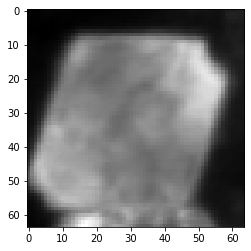

In [5]:
# inner and outer radius
in_rad = 12
out_rad = 50

generateAdf(data_ori,in_rad,out_rad)

The pre-process of the data includes checking if there are NaN values and replacing them as zeros to avoid missing values causing errors. Also, a small number is added to the data so that the following calculations would not be stuck with a problem like devision by 0.

In [6]:
data = copy.deepcopy(data_ori)

data[np.where(np.isnan(data)==True)] = 0

data -= data.min() if data.min()< 0 else 0
data += 10**(-17)

In [7]:
# If we want to make the dim disks more visible, we can take the square root of the original values in the dataset, 
# which decreases the contrast
# data[:,:] = np.sqrt(data[:,:])

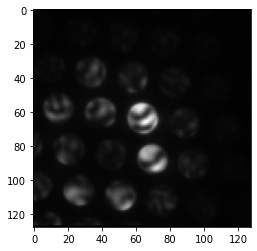

In [8]:
# We can visualize any 2D array with the visual function

show_one_pat = visual(data[30,30])

## 2. Build an average pattern

After read in and pre-process the 4D-STEM data, an average pattern can be generated by stacking all the diffraction patterns. This pattern can be used to estimate the position and radius of the center disk.

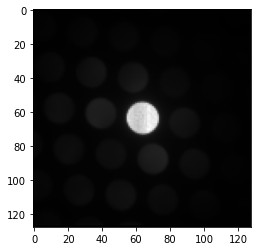

In [9]:
avg_pat = generateAvg(data)
show_avg = visual(avg_pat)

## 3. Disk registration on the average pattern

Next step is to detect diffraction disks and find two lattice parameters on the average pattern. The estimated lattice parameters can be used as the references in the strain mapping process. As an example of disk registration, each step will be visualized to show how AutoDisk works on a typical CBED pattern.

### 1) Find center and radius
The center of the zero-order disk may not align with the center of the diffraction pattern. So, it is necessary to find the center of the zero-order disk and estimate the radius of it. We then use this radius as the radius of the diffraction disks in all CBED patterns.

Center of the zero-order disk is [63.5 64. ]. The radius of the disk is 9.25.


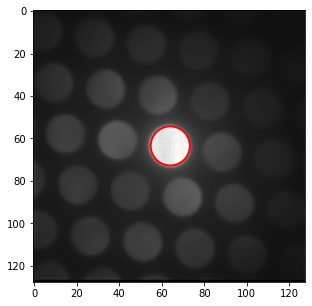

In [10]:
ctr_ori,r = ctrRadiusIni(avg_pat)
print('Center of the zero-order disk is {}. The radius of the disk is {}.'.format(ctr_ori,r))

fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(np.sqrt(avg_pat),cmap='gray')
y, x = ctr_ori
c = plt.Circle((x, y),r, color='red', linewidth=2, fill=False)
ax.add_patch(c)
plt.show()

### 2) Build a ring kernal for cross-correlation
The next step is to generate a ring kernel for cross-correlation. The shape of the ring should be consistant with the shape of the center disk so the kernels would work even when aberrations lead to ellipse diffraction disks.<br>
The radius of the ring should be sligntly smaller than the radius of the disk we found in step 1).

As a backup choice, if we are not able to generate a ring kernel from the average pattern successfully, there is a pre-defined ring kernal, which can be loaded by adding "pre_def=True" to the genrateKernel function. There are two hyper-parameters that can be modified according to the data.

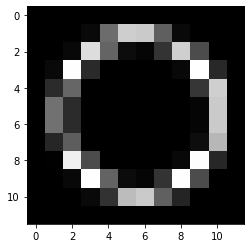

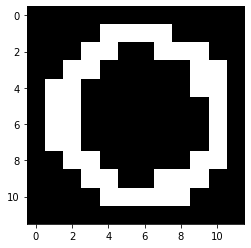

In [11]:
kernel = genrateKernel(avg_pat,ctr_ori,r,0.7,2)
kernel_out = visual(kernel)

kernel[kernel < kernel.mean()] = 0
kernel[kernel !=0] = 1
kernel_out = visual(kernel)

### 3) Generate the cross-correlated pattern.

The average diffraction pattern is cross-correlated by the kernel. The ideal cross-correlated map should have many slightly overlapped plate patterns with bright center blobs, with each pattern corrsponding to a diffraction disk on the original pattern.

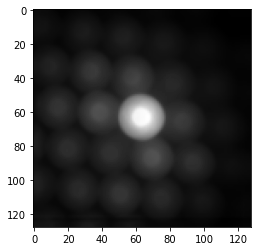

In [12]:
cros_map = crossCorr(avg_pat,kernel)

show_cros_map = visual(cros_map)

### 4) Detect center blobs

Then, blob detection using Laplacian of Gaussian filters is applied on the cross-correlated map. It should be noticed that sometimes, the detected disk positions via this blob detection step would not be accurate due to the shift to a partial bright area. That's why a further refinement step is necessary.

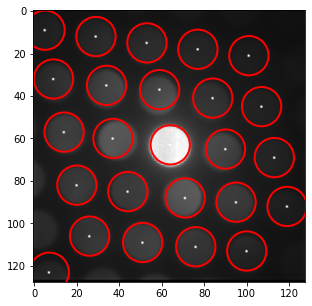

In [13]:
blobs = ctrDet(cros_map, r, kernel, 10, 5)

drawCircles(np.sqrt(avg_pat),blobs,r)

### 5) Refine disk positions with radial gradient maximum

To refine disk positions, the radial gradient maximum method is adapted. This step would return refined disk centers and a weight assigned to each disk position. The weight lower than a threshold would be labeled as noise and the corresponding disk center would be disgarded.

[[ 64.  64.]
 [ 61.  40.]
 [ 87.  69.]
 [ 37.  33.]
 [109.  51.]
 [ 58.  15.]
 [ 40.  58.]
 [ 82.  21.]
 [ 91.  94.]
 [106.  26.]
 [ 67.  88.]
 [112.  76.]
 [ 34.   9.]
 [ 84.  45.]
 [ 16.  52.]
 [ 13.  28.]
 [ 43.  82.]
 [115. 100.]
 [119.   3.]
 [ 19.  77.]
 [ 10.   3.]
 [ 70. 113.]
 [ 46. 107.]
 [ 22. 102.]
 [ 94. 119.]]


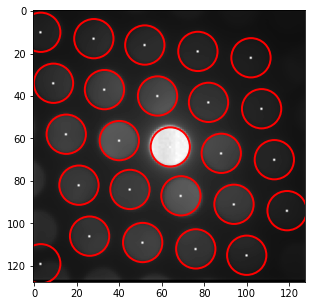

In [14]:
ref_ctr = radGradMax(avg_pat, blobs, r,ra=4)

ref_blobs_list = ref_ctr[:,:2]
print(ref_blobs_list)
drawCircles(np.sqrt(avg_pat),ref_blobs_list,r)

### 6) Detect the angle to rotate the coordinate systems
The angle is estimated, used for rotation of the coordinate system, so one row of the disks would be along the x-axis of the new coordinate system. Also, the center of the new coordinate system would be assigned a large weight, updated in the returned disk position list.

In [15]:
angle, refined_ctr = detAng(ref_ctr,ctr_ori,r)

print('Estimated rotation angle: ',angle,'(deg)')

# Generate the coordinate of centers in the new coordinate system 
rot_ref_ctr = rotCtr(avg_pat,ref_ctr,angle)   

Estimated rotation angle:  6.905181511707201 (deg)


### 7) Lattice fitting
This step generates two lattice vectors: vecter a, called the horizontal lattice vector which is along the x-axis of the new coordinate system, and vector b, which points to another non-horizontal direction. Also, during to the fitting process, the rotation angle would be refined, thus the coordinate system may be slightly adjusted. Based on the new coordinate system, the disk centers would also be refined.

In [16]:
refe_a,refe_b,ref_ctr2, mid_ctr,ref_ang = latFit(avg_pat,rot_ref_ctr,r)

print(ref_ctr2)

print('Two lattice vectors: vector_a--[',refe_a[0],refe_a[1], '] and vector_b--[',refe_b[0],refe_b[1],']')

[[6.40000000e+01 6.40000000e+01 1.00000000e+38]
 [6.40000000e+01 3.98132744e+01 2.37060975e+12]
 [8.65660880e+01 7.17701165e+01 2.34123076e+12]
 [4.09413886e+01 2.99360483e+01 1.34558126e+12]
 [1.10247479e+02 5.65901604e+01 1.24563820e+12]
 [6.40000000e+01 1.46340267e+01 1.17213146e+12]
 [4.09413886e+01 5.51152959e+01 1.79459593e+12]
 [8.65660880e+01 2.35187308e+01 9.69791005e+11]
 [8.65660880e+01 9.70714297e+01 1.05744785e+12]
 [1.10247479e+02 3.14109128e+01 9.19227962e+11]
 [6.40000000e+01 8.81867256e+01 1.49075039e+12]
 [1.10247479e+02 8.17694081e+01 9.07659217e+11]
 [4.09413886e+01 5.74932264e+00 6.88807580e+11]
 [8.65660880e+01 4.75833909e+01 1.17387574e+12]
 [1.77694459e+01 4.62305919e+01 5.81417347e+11]
 [1.77694459e+01 2.20438663e+01 4.97376594e+11]
 [4.09413886e+01 7.93020216e+01 8.97824022e+11]
 [1.10247479e+02 1.05956134e+02 4.16098050e+11]
 [1.26034708e+02 1.01697570e+01 3.67051018e+11]
 [1.77694459e+01 7.14098396e+01 4.65869746e+11]
 [6.40000000e+01 1.13365973e+02 4.076089

### 8) Generate hypothetical lattice

After two vectors are determined, a lattice matrix is generated based on vector a and vector b.

In [ ]:
gen_lat_pt = genLat(avg_pat, refe_a, refe_b, mid_ctr,r)
print(gen_lat_pt)

In [ ]:
result_pt = delArti(gen_lat_pt,ref_ctr2,r)
rot_pat = rotImg(avg_pat, angle+ref_ang, ctr_ori)
drawCircles(np.sqrt(rot_pat),result_pt,r)

### 9) Define coordinate system and visualize disks on the pattern
The same lattice vectors would be represented differently in varying coordinate systems, resulting in totally different strain maps. In this demo, we use the default horizontal and vertical directions of the CBED patterns as x and y axes, and transform the lattice vectors and the following strain maps to this coordinate system.
The generated hypothetical lattice points are compared with the detected disk positions. Any lattice point that is not detected in the pattern would be disgarded. The final disk registration result is then plotted.

In [ ]:
a_init,b_init = latBack(refe_a, refe_b, angle)

In [ ]:
ctr_new = []
ang_rad = -(angle)*np.pi/180
ctr = mid_ctr[0]

for q in range (len(result_pt)):
    cur_cd = result_pt[q,:2]
    y_new = -(ctr[0] - (cur_cd[0]-ctr[0])*np.cos(ang_rad) + (cur_cd[1]-ctr[1])*np.sin(ang_rad) ) + 2*ctr[0]
    x_new = (ctr[1] + (cur_cd[0]-ctr[0])*np.sin(ang_rad) + (cur_cd[1]-ctr[1])*np.cos(ang_rad) )

    if y_new>0 and x_new>0 and y_new<pxh and x_new<pxw:
        ctr_new.append([y_new,x_new])

ctr_new = np.array(ctr_new)

vis_ctr = np.round(ctr_new,0)
vis_ctr.astype(int)

drawCircles(np.sqrt(avg_pat),vis_ctr,r)

## 4. Disk registration on the dataset

We use almost the same process on each CBED pattern in the 4D dataset to get the lattice parameters at each probe position.

In [ ]:
import time
lat_par = np.zeros((imgh,imgw,2,2),dtype = float)

for row_idx in range (imgh):
    for col_idx in range (imgw):
        pattern = data[row_idx,col_idx]
        
        cros_map = crossCorr(pattern,kernel)   
        blobs = ctrDet(cros_map, r, kernel, 10, 10) 
        
        if len(blobs) > 5:
            ctr_cur,r_cur = ctrRadiusIni(pattern)
            if np.linalg.norm(ctr_cur-ctr_ori) <= 2: # 2px
                ctr = ctr_cur
            else:
                ctr = ctr_ori
                ctr[1] = round(ctr[1])
                ctr[0] = round(ctr[0])              
            
            ref_ctr = radGradMax(pattern, blobs, r,rn=20, ra=2, n_p=40, threshold=3)           
            
            ctr_vec = ref_ctr[:,:2] - ctr
            ctr_diff = ctr_vec[:,0]**2 + ctr_vec[:,1]**2
            ctr_idx = np.where(ctr_diff==ctr_diff.min())[0][0]
            ref_ctr[ctr_idx,2] = 10**38
            rot_ref_ctr = rotCtr(pattern,ref_ctr,angle)
            ret_a,ret_b,ref_ctr2, mid_ctr,ref_ang = latFit(pattern,rot_ref_ctr,r)
            
            if any(ret_a!=0) and any(ret_b!=0):
                a_back,b_back = latBack(ret_a, ret_b, angle+ref_ang)             
                
                lat_par[row_idx,col_idx,0,:] = a_back
                lat_par[row_idx,col_idx,1,:] = b_back  
            print(f'Process {os.getpid()} returned [{a_back},{b_back}] for r:{row_idx}, c: {col_idx}')              
              

    print('Processed {} out of {} rows of patterns.'.format(row_idx+1,imgh))
    
print('-------------------Process Finished-------------------')

## 5. Check outliers of lattice parameters

This step is important to filter out any patterns whose lattice parameters differ a lot from that of the averaged pattern. A default threshod is set as the difference between the lattice parameters should not be more than 20% of the values of the reference values. This threshold can be modified based on the data. The output lattice parameters can be used for mapping strain and lattice parameter distributions.

In [ ]:
lat_fil = latDist(lat_par,a_init,b_init)

## 6. Calculate strain

To calculate the strain, the lattice parameters output from the averaged pattern are used as the references.
 This function calculates the normal and shear stain given the filtered lattice parameters.

In [ ]:
st_xx,st_yy,st_xy,st_yx,tha_ang = calcStrain(lat_fil, a_init,b_init)

## 7. Plot strain maps

Finally, we plot the stain maps.

In [ ]:
rdbu = plt.cm.get_cmap('RdBu')
cmap_re = rdbu.reversed()
  
input_min=-0.058
input_max=0.058

l_min = input_min*100
l_max = input_max*100

titles = ["$\epsilon_{xx}(\%)$","$\epsilon_{yy}(\%)$","$\epsilon_{xy}(\%)$","$\Theta$"]
comb = [st_xx,st_yy,st_xy,tha_ang]

fig,axs = plt.subplots(2,2,figsize = (10,10))
i=0
for row in range (2):
    for col in range (2):
        if row==1 and col==1:
            ax = axs[row,col]
            pcm = ax.imshow(comb[i],cmap=cmap_re,vmin=l_min,vmax=l_max)
            ax.set_title(titles[i],fontsize=28)
            ax.set_axis_off()
            fig.colorbar(pcm,ax=ax)
            i +=1
        else:    
            ax = axs[row,col]
            pcm = ax.imshow(comb[i]*100,cmap=cmap_re,vmin=l_min,vmax=l_max)
            ax.set_title(titles[i],fontsize=28)
            ax.set_axis_off()
            fig.colorbar(pcm,ax=ax)
            i +=1
       
plt.subplots_adjust(wspace=0.25,hspace=0.25)
plt.show()

In [ ]:
from datetime import datetime
import csv

def saveResults(results):
    filename = str(datetime.now()).split('.')[0].replace(':','_') + '.csv'
    with open(filename,'w',newline='') as f:
        writer = csv.writer(f)
        writer.writerows(results)

saveResults(lat_par)